In [1]:
import numpy as np

opt_root_path = '/data/qq/CSCE689/'

x_train_1 = np.load(opt_root_path + 'feature_ucf_all/resnext101_avgpool_train.npy')
x_train_2 = np.load(opt_root_path + 'feature_ucf_all/resnet50_avgpool_train.npy')

x_val_1 = np.load(opt_root_path + 'feature_ucf_all/resnext101_avgpool_val.npy')
x_val_2 = np.load(opt_root_path + 'feature_ucf_all/resnet50_avgpool_val.npy')

x_test_1 = np.load(opt_root_path + 'feature_ucf_all/resnext101_avgpool_test.npy')
x_test_2 = np.load(opt_root_path + 'feature_ucf_all/resnet50_avgpool_test.npy')

In [5]:
x_train_1.shape, x_train_1.shape

((114779, 2048), (114779, 2048))

### Introduction of the ideas

The core idea of my improved action detection model is to leverage the ensemble learning by extracting and fusing the last layer feature maps learned from different pretrained models. A simple way to fuse the features is to concatenate them and append a linear classification head in the end.

In [1]:
import os
import sys
import json
import numpy as np
import torch
from torch import nn
from torch import optim
from torch.optim import lr_scheduler

from opts import parse_opts
from mean import get_mean, get_std
from spatial_transforms import (
    Compose, Normalize, Scale, CenterCrop, CornerCrop, MultiScaleCornerCrop,
    MultiScaleRandomCrop, RandomHorizontalFlip, ToTensor)
from temporal_transforms import LoopPadding, TemporalRandomCrop
from target_transforms import ClassLabel, VideoID
from target_transforms import Compose as TargetCompose
from dataset import get_training_set, get_validation_set, get_test_set
from utils import Logger
from train import train_epoch
from validation import val_epoch
import test
import collections
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from joblib import dump, load
from sklearn import preprocessing
from scipy import stats
from sklearn.metrics import accuracy_score

from models import *

In [2]:
# use two gpu devices on the server, you can customize it depending on how many available gpu devices you have
os.environ['CUDA_VISIBLE_DEVICES']='0'

### Set hyperparameters 

In [3]:

import easydict
opt = easydict.EasyDict({
    "result_path": 'hw6_results',      # 'Result directory path'
    "n_classes": 8,                 # 'Number of classes for fine-tuning'
    "sample_size": 112,             # 'Height and width of inputs'
    "sample_duration": 16,          # 'Temporal duration of inputs'
    "initial_scale": 1.0,           # 'Initial scale for multiscale cropping')
    "n_scales": 5,                  # 'Number of scales for multiscale cropping'
    "scale_step": 0.84089641525,    # 'Scale step for multiscale cropping'
    "train_crop": 'corner',         # 'Spatial cropping method in training. Corner is selection from 4 corners and 1 center.
    "learning_rate": 0.1,           # 'Initial learning rate (divided by 10 while training by lr scheduler)'
    "momentum": 0.9,                # 'Momentum'
    "dampening": 0.9,               # 'Dampening of SGD'
    "weight_decay": 0.001,          # 'Weight decay in SGD'
    "mean_dataset": 'kinetics',     # 'Dataset for mean values of mean subtraction'
    "no_mean_norm": False,          # 'If true, inputs are not normalized by mean'
    "std_norm": False,              # 'If true, inputs are normalized by standard deviation'
    "nesterov": False,              # 'Nesterov momentum'
    "optimizer": 'sgd',             # 'Optimizer type'
    "lr_patience": 10,              # 'Patience of LR scheduler. See documentation of Reduce on Loss Plateau Decay (ReduceLROnPlateau). https://www.deeplearningwizard.com/deep_learning/boosting_models_pytorch/lr_scheduling/#reduce-on-loss-plateau-decay'
    "batch_size": 32,               # 'Batch size'
    "n_epochs": 200,                  # 'Fine-tuning epochs'
    "begin_epoch": 1,               # 'Training begins at this epoch. Previous trained model indicated by resume_path is loaded.'
    "n_val_samples": 3,             # 'Number of validation samples for each activity'
    "ft_begin_index": 5,            # 'Begin block index of fine-tuning'
    "scale_in_test": 1.0,           # 'Spatial scale in test'
    "crop_position_in_test": 'c',   #  Cropping method: center cropping
    "no_softmax_in_test": False,    # 'If true, output for each clip is not normalized using softmax.'
    "no_cuda": False,               # 'If true, cuda is not used.'
    "n_threads": 4,                 # 'Number of threads for multi-thread loading'
    "checkpoint": 2,                #  Trained model is saved at every this epochs'
    "no_hflip": False,              # 'If true holizontal flipping is not performed'
    "norm_value": 1,                # 'If 1, range of inputs is [0-255]. If 255, range of inputs is [0-1].'
    "model_depth": 101,             # 'Depth of resnet 
    "resnet_shortcut": 'B',         # 'Shortcut type of resnet' to align the dimensionality for skip connection
    "wide_resnet_k": 2,             # 'Wide resnet k'
    "resnext_cardinality": 32,      # 'ResNeXt cardinality'
    "manual_seed": 1,               # 'Manually set random seed'
    'test_subset': 'test',          # 'Used test subset name'
})
# opt.arch = '{}-{}'.format(opt.model, opt.model_depth)
opt.root_path = '/data/qq/CSCE689/'
opt.video_path = opt.root_path + 'video/activitynet_music/'
opt.annotation_path = opt.root_path + 'video/activitynet_music_annotation/activity_net_music_w_testing.json'

### Load and preprocess ActivityNet-music dataset

In [4]:
# load preprocessed video frames and annotation
from datasets.activitynet import ActivityNet

mean = get_mean(opt.norm_value, dataset='kinetics')
std = get_std(opt.norm_value)
norm_method = Normalize(mean, [1,1,1])


spatial_transform = Compose([
    Scale(opt.sample_size),
    CornerCrop(opt.sample_size, 'c'),
    ToTensor(opt.norm_value), norm_method
])

temporal_transform = LoopPadding(opt.sample_duration)
target_transform = ClassLabel() # VideoID()

# get training data
training_data = ActivityNet(
    opt.video_path,
    opt.annotation_path,
    'training',
    False,
    0,
    spatial_transform=spatial_transform,
    temporal_transform=temporal_transform,
    target_transform=target_transform,
    sample_duration=16)

# wrap training data
train_loader = torch.utils.data.DataLoader(
    training_data,
    batch_size=opt.batch_size,
    shuffle=False,
    num_workers=opt.n_threads,
    pin_memory=False) # True


# get validation data
val_data = ActivityNet(
    opt.video_path,
    opt.annotation_path,
    'validation',
    False,
    0,
    spatial_transform=spatial_transform,
    temporal_transform=temporal_transform,
    target_transform=target_transform,
    sample_duration=16)

# wrap validation data
val_loader = torch.utils.data.DataLoader(
    val_data,
    batch_size=opt.batch_size,
    shuffle=False,
    num_workers=opt.n_threads,
    pin_memory=False) 



# Directly predict videoID for test data
target_transform = VideoID()

# get test data
test_data = ActivityNet(
    opt.video_path,
    opt.annotation_path,
    'testing',
    False,
    0,
    spatial_transform=spatial_transform,
    temporal_transform=temporal_transform,
    target_transform=target_transform,
    sample_duration=16)


# wrap test data
test_loader = torch.utils.data.DataLoader(
    test_data,
    batch_size=opt.batch_size,
    shuffle=False,
    num_workers=opt.n_threads,
    pin_memory=False)

dataset loading [0/729]
dataset loading [0/126]
dataset loading [0/123]


### Extract features of ResNeXt - 101 and save in disk

In [5]:
# from models import resnext

# # construct model architecture
# model_rxt101 = resnext.resnet101(
#                 num_classes=opt.n_classes,
#                 shortcut_type=opt.resnet_shortcut,
#                 cardinality=opt.resnext_cardinality,
#                 sample_size=opt.sample_size,
#                 sample_duration=opt.sample_duration)

# model_rxt101 = model_rxt101.cuda()
# # wrap the current model again in nn.DataParallel / or we can just remove the .module keys.
# model_rxt101 = nn.DataParallel(model_rxt101, device_ids=None)


# ### Load pretrained weight
# # customize the pretrained model path
# pretrain = torch.load(opt.root_path + 'pretrain/resnext-101-kinetics.pth')
# pretrain_dict = pretrain['state_dict']

# # do not load the last layer since we want to fine-tune it
# pretrain_dict.pop('module.fc.weight')
# pretrain_dict.pop('module.fc.bias')
# model_dict = model_rxt101.state_dict()
# model_dict.update(pretrain_dict) 
# model_rxt101.load_state_dict(model_dict)

In [6]:
# # register layer index to extract the features by forwarding all the video clips
# activation = {}
# def get_activation(name):
#     def hook(model, input, output):
#         activation[name] = output.detach()
#     return hook

# model_rxt101.module.avgpool.register_forward_hook(get_activation('avgpool'))
# model_rxt101.eval()


# # forward all the videos to extract features
# avgpool, avgpool_val, avgpool_test = [], [], []
# targets, targets_val, targets_test = [], [], []
# with torch.no_grad():
#     print("Extract train set features:")
#     for i, (inputs, target) in enumerate(train_loader):
#         if i % 30 == 0:
#             print(i)
#         output = model_rxt101(inputs)
#         avgpool.append(activation['avgpool'].view(len(target), -1).cpu())
#         targets.append(target)
    
#     print("Extract val set features:")
#     for i, (inputs, target) in enumerate(val_loader):
#         if i % 30 == 0:
#             print(i)
#         output = model_rxt101(inputs)
#         avgpool_val.append(activation['avgpool'].view(len(target), -1).cpu())
#         targets_val.append(target)
 
#     print("Extract test set features:")
#     for i, (inputs, target) in enumerate(test_loader):
#         if i % 30 == 0:
#             print(i)
#         output = model_rxt101(inputs)
#         avgpool_test.append(activation['avgpool'].view(len(target), -1).cpu())
#         targets_test.append(target)

In [7]:
# # save the features
# avgpool_np = np.concatenate([i.numpy() for i in avgpool], axis=0)
# np.save(opt.root_path + 'features-activitynet/resnext101_avgpool_train.npy', avgpool_np)

# targets_np = np.concatenate([i.numpy() for i in targets], axis=0)
# np.save(opt.root_path + 'features-activitynet/class_names_activitynet_train.npy', targets_np)

# avgpool_val_np = np.concatenate([i.numpy() for i in avgpool_val], axis=0)
# np.save(opt.root_path + 'features-activitynet/resnext101_avgpool_val.npy', avgpool_val_np)

# targets_val_np = np.concatenate([i.numpy() for i in targets_val], axis=0)
# np.save(opt.root_path + 'features-activitynet/class_names_activitynet_val.npy', targets_val_np)

# avgpool_test_np = np.concatenate([i.numpy() for i in avgpool_test], axis=0)
# np.save(opt.root_path + 'features-activitynet/resnext101_avgpool_test.npy', avgpool_test_np)

# targets_test_np = np.concatenate(np.array(targets_test), axis=0)
# np.save(opt.root_path + 'features-activitynet/class_names_activitynet_test.npy', targets_test_np)

### Extract features of ResNet-50 and save in disk

In [8]:
# from models import resnet

# # construct model architecture
# model_rt50 = resnet.resnet50(
#                 num_classes=opt.n_classes,
#                 shortcut_type=opt.resnet_shortcut,
#                 sample_size=opt.sample_size,
#                 sample_duration=opt.sample_duration)

# model_rt50 = model_rt50.cuda()
# # wrap the current model again in nn.DataParallel / or we can just remove the .module keys.
# model_rt50 = nn.DataParallel(model_rt50, device_ids=None)


# ### Load pretrained weight
# # customize the pretrained model path
# pretrain = torch.load(opt.root_path + 'pretrain/resnet-50-kinetics.pth')
# pretrain_dict = pretrain['state_dict']

# # do not load the last layer since we want to fine-tune it
# pretrain_dict.pop('module.fc.weight')
# pretrain_dict.pop('module.fc.bias')
# model_dict = model_rt50.state_dict()
# model_dict.update(pretrain_dict) 
# model_rt50.load_state_dict(model_dict)


In [9]:
# # register layer index to extract the features by forwarding all the video clips
# activation = {}
# def get_activation(name):
#     def hook(model, input, output):
#         activation[name] = output.detach()
#     return hook

# model_rt50.module.avgpool.register_forward_hook(get_activation('avgpool'))
# model_rt50.eval()


# # forward all the videos to extract features
# avgpool, avgpool_val, avgpool_test = [], [], []
# with torch.no_grad():
#     print("Extract train set features:")
#     for i, (inputs, target) in enumerate(train_loader):
#         if i % 30 == 0:
#             print(i)
#         output = model_rt50(inputs)
#         avgpool.append(activation['avgpool'].view(len(target), -1).cpu())
    
#     print("Extract val set features:")
#     for i, (inputs, target) in enumerate(val_loader):
#         if i % 30 == 0:
#             print(i)
#         output = model_rt50(inputs)
#         avgpool_val.append(activation['avgpool'].view(len(target), -1).cpu())
 
#     print("Extract test set features:")
#     for i, (inputs, target) in enumerate(test_loader):
#         if i % 30 == 0:
#             print(i)
#         output = model_rt50(inputs)
#         avgpool_test.append(activation['avgpool'].view(len(target), -1).cpu())

# # save the features
# avgpool_np = np.concatenate([i.numpy() for i in avgpool], axis=0)
# np.save(opt.root_path + 'features-activitynet/resnet50_avgpool_train.npy', avgpool_np)

# avgpool_val_np = np.concatenate([i.numpy() for i in avgpool_val], axis=0)
# np.save(opt.root_path + 'features-activitynet/resnet50_avgpool_val.npy', avgpool_val_np)

# avgpool_test_np = np.concatenate([i.numpy() for i in avgpool_test], axis=0)
# np.save(opt.root_path + 'features-activitynet/resnet50_avgpool_test.npy', avgpool_test_np)

### Load and fuse (concatenate) features and fine-tune an appended classification layer

In [10]:
x_train_1 = np.load(opt.root_path + 'features-activitynet/resnext101_avgpool_train.npy')
x_train_2 = np.load(opt.root_path + 'features-activitynet/resnet50_avgpool_train.npy')

x_val_1 = np.load(opt.root_path + 'features-activitynet/resnext101_avgpool_val.npy')
x_val_2 = np.load(opt.root_path + 'features-activitynet/resnet50_avgpool_val.npy')

x_test_1 = np.load(opt.root_path + 'features-activitynet/resnext101_avgpool_test.npy')
x_test_2 = np.load(opt.root_path + 'features-activitynet/resnet50_avgpool_test.npy')

y_train = np.load(opt.root_path + 'features-activitynet/class_names_activitynet_train.npy')
y_val = np.load(opt.root_path + 'features-activitynet/class_names_activitynet_val.npy')
y_test = np.load(opt.root_path + 'features-activitynet/class_names_activitynet_test.npy')
y = np.concatenate([y_train, y_val], axis=0)

x_train = np.concatenate([x_train_1, x_train_2], axis=1)
x_val = np.concatenate([x_val_1, x_val_2], axis=1)
x_test = np.concatenate([x_test_1, x_test_2], axis=1)
X = np.concatenate([x_train, x_val], axis=0)

In [11]:
x_train.shape, x_val.shape, x_test.shape, y_train.shape, y_val.shape, y_test, len(y_test)

((1160, 4096),
 (197, 4096),
 (198, 4096),
 (1160,),
 (197,),
 array(['-XQZFgiqz0k', '-XQZFgiqz0k', '0RIc6mwDRaQ', '0rsDCQsmTWk',
        '0rsDCQsmTWk', '17bafV-ZesY', '17bafV-ZesY', '1ct-UuBcV9Y',
        '1ct-UuBcV9Y', '224E-VtB4k4', '224E-VtB4k4', '2BQ-8BD0mAM',
        '2BQ-8BD0mAM', '2HzKrBd3BR8', '2HzKrBd3BR8', '2lL9DxwQQbU',
        '3MNDofBd6Hk', '3WmEItLTQeM', '3WmEItLTQeM', '3ZA_UFn_sRk',
        '3ZA_UFn_sRk', '3fyR5F18WKg', '3fyR5F18WKg', '3xp_PXnb5W8',
        '41WtX5hVOqg', '45WdXofnTkI', '4SSbyJ6pMuE', '4qe__9Pr4uY',
        '5E2OdhrgG8s', '5I60gr0ZQfw', '5I60gr0ZQfw', '62QMpyPxlRY',
        '62QMpyPxlRY', '6NRfb72Ku24', '6NRfb72Ku24', '6NRfb72Ku24',
        '72xE6N4QVEM', '72xE6N4QVEM', '7TdqeG4ZHtU', '7o7hL0VccJQ',
        '8AQopjogplo', '8AQopjogplo', '8_XQPqLdblg', '8_XQPqLdblg',
        '8dinBrj2CB8', '8dinBrj2CB8', '993xtlhuVII', '993xtlhuVII',
        '9GYLUAFgCXE', '9Hxcuf80TK0', '9Hxcuf80TK0', '9kXfywaiAjo',
        '9nNGlaiVypU', 'AGIzlJit_OQ', 'AcsapIC6ez4', '

### Get ground truth test labels

In [12]:
with open(opt.annotation_path) as rfp:
    annotations = json.load(rfp)

ground_truth_all = []
for k in y_test:
    ground_truth_all.append(list(annotations['database'][k]['annotations'].keys())[0])

In [13]:
len(ground_truth_all), ground_truth_all[:5]

(198,
 ['Playing guitarra',
  'Playing guitarra',
  'Playing flauta',
  'Playing flauta',
  'Playing flauta'])

In [14]:
name_to_int = {v:k for k,v in test_data.class_names.items()}

split_idx = []
for idx, y_name in enumerate(y_test):
    if idx == 0 or y_name != y_test[idx-1]:
        split_idx.append(idx)

ground_truth = []
for i, split in enumerate(split_idx):
    if i < len(split_idx) - 1:
        ground_truth.append(name_to_int[ground_truth_all[split]])
        

### Fine-tune the pretrained model on the target ActivityNet dataset

#### Fit three linear SVM on (1) ResNeXt features (2) ResNet features (3) Combined features

In [12]:
# # Import library for support vector machine classifier
# from sklearn.svm import SVC


# # Create a support vector classifier
# clf1 = SVC(C=1, kernel='linear', random_state=42, probability=True)
# clf2 = SVC(C=1, kernel='linear', random_state=42, probability=True)
# clf = SVC(C=1, kernel='linear', random_state=42, probability=True) # combine


# # Train the model using the training sets
# clf1.fit(x_train_1, y_train)
# clf2.fit(x_train_2, y_train)
# clf.fit(x_train, y_train) # combine

In [13]:
# # save model
# dump(clf1, './hw6_results/linearsvc1.joblib') 
# dump(clf2, './hw6_results/linearsvc2.joblib') 
# dump(clf, './hw6_results/linearsvc.joblib') 

In [14]:
# load model
clf1 = load('./hw6_results/linearsvc1.joblib') 
clf2 = load('./hw6_results/linearsvc2.joblib') 
clf = load('./hw6_results/linearsvc.joblib') 

In [15]:
# Get Test Probability
y_test_prob1 = clf1.predict_proba(x_test_1)
y_test_prob2 = clf2.predict_proba(x_test_2)
y_test_prob = clf.predict_proba(x_test)

In [16]:
# # cross validation (take long time)
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import make_scorer


# # Create a dictionary for all the hyperparameters
# hps = {
#   'C': [0.05, 0.1, 0.5, 1, 5, 10],
#   'kernel': ['linear', 'rbf'],  
# }

# # Construct a scoring function for performance estimation.
# scoring_fnc = make_scorer(accuracy_score)

# # Create the grid search cv object (5-fold cross-validation)
# grid_search = GridSearchCV(estimator=clf, 
#                            param_grid=hps, 
#                            scoring=scoring_fnc, 
#                            cv=3,
#                            verbose=5,
#                            n_jobs=10) 

# # Fit the grid search object to the training data to search the optimal model
# grid_search = grid_search.fit(X, y)

### Test, compare the models

#### Performance of the resnext101 model with last fc layer fine-tuned (ResNeXt-101 feature + fc layer + softmax)

In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import StepLR

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc = nn.Linear(2048, opt.n_classes)

    def forward(self, x):
        x = self.fc(x)
        output = F.log_softmax(x, dim=1)
        return output
    
def train(args, model, device, train_loader, optimizer, epoch, val_loader=None):
    for batch_idx, (data, target) in enumerate(train_loader):
        model.train()
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        
        if val_loader is not None:
            model.eval()
            val_loss = 0
            correct = 0
            with torch.no_grad():
                for data, target in val_loader:
                    data, target = data.to(device), target.to(device)
                    output = model(data)
                    val_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
                    pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
                    correct += pred.eq(target.view_as(pred)).sum().item()
            val_loss /= len(val_loader.dataset)      
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tVal_Loss: {:.6f}\tVal_Acc: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item(), val_loss, 100. * correct / len(val_loader.dataset)))
     
    print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tVal_Loss: {:.6f}\tVal_Acc: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item(), val_loss, 100. * correct / len(val_loader.dataset)))

    return loss, val_loss

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


In [35]:
    
use_cuda = not opt.no_cuda and torch.cuda.is_available()

# torch.manual_seed(42)

device = torch.device("cuda" if use_cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}


class MyDataset(Dataset):
    def __init__(self, data, target, transform=None):
        self.data = torch.from_numpy(data).float()
        self.target = torch.from_numpy(target).long()
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        
        if self.transform:
            x = self.transform(x)
        
        return x, y
    
    def __len__(self):
        return len(self.data)


train_loader = torch.utils.data.DataLoader(MyDataset(x_train_1, y_train), batch_size=opt.batch_size, shuffle=True, **kwargs)
val_loader = torch.utils.data.DataLoader(MyDataset(x_val_1, y_val), batch_size=opt.batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(MyDataset(x_test_1, y_train), batch_size=opt.batch_size, shuffle=True, **kwargs)

model = Net().to(device)
if opt.nesterov:
    dampening = 0
else:
    dampening = opt.dampening
    
optimizer = optim.SGD(
            model.parameters(),
            lr=opt.learning_rate,
            momentum=opt.momentum,
            dampening=dampening,
            weight_decay=opt.weight_decay,
            nesterov=opt.nesterov)

scheduler = lr_scheduler.ReduceLROnPlateau(
    optimizer, 'min', patience=opt.lr_patience)

for epoch in range(1, opt.n_epochs + 1):
    loss, val_loss = train(opt, model, device, train_loader, optimizer, epoch, val_loader)
    test(model, device, test_loader)
    scheduler.step(val_loss)


# torch.save(model.state_dict(), "./hw6_results/fine_tune_resnext101.pt")

Train Epoch: 1 [0/1160 (0%)]	Loss: 2.058742	Val_Loss: 2.073908	Val_Acc: 25.380711
Train Epoch: 1 [180/1160 (97%)]	Loss: 0.560975	Val_Loss: 1.976650	Val_Acc: 45.685279

Test set: Average loss: 5.2418, Accuracy: 27/198 (14%)

Train Epoch: 2 [0/1160 (0%)]	Loss: 1.263320	Val_Loss: 1.963594	Val_Acc: 46.192893
Train Epoch: 2 [180/1160 (97%)]	Loss: 1.139867	Val_Loss: 1.961299	Val_Acc: 42.131980

Test set: Average loss: 5.1256, Accuracy: 32/198 (16%)

Train Epoch: 3 [0/1160 (0%)]	Loss: 0.900498	Val_Loss: 1.982792	Val_Acc: 42.639594
Train Epoch: 3 [180/1160 (97%)]	Loss: 1.094050	Val_Loss: 1.923592	Val_Acc: 43.654822

Test set: Average loss: 5.0367, Accuracy: 23/198 (12%)

Train Epoch: 4 [0/1160 (0%)]	Loss: 0.816374	Val_Loss: 1.935629	Val_Acc: 43.147208
Train Epoch: 4 [180/1160 (97%)]	Loss: 0.967878	Val_Loss: 1.962470	Val_Acc: 44.162437

Test set: Average loss: 5.0204, Accuracy: 22/198 (11%)

Train Epoch: 5 [0/1160 (0%)]	Loss: 0.960914	Val_Loss: 1.932114	Val_Acc: 45.177665
Train Epoch: 5 [180/11

Train Epoch: 37 [180/1160 (97%)]	Loss: 0.309966	Val_Loss: 2.086220	Val_Acc: 45.685279

Test set: Average loss: 5.5704, Accuracy: 20/198 (10%)

Train Epoch: 38 [0/1160 (0%)]	Loss: 0.511621	Val_Loss: 2.086212	Val_Acc: 45.685279
Train Epoch: 38 [180/1160 (97%)]	Loss: 0.750847	Val_Loss: 2.086210	Val_Acc: 45.685279

Test set: Average loss: 5.5703, Accuracy: 20/198 (10%)

Train Epoch: 39 [0/1160 (0%)]	Loss: 0.390563	Val_Loss: 2.086203	Val_Acc: 45.685279
Train Epoch: 39 [180/1160 (97%)]	Loss: 0.681488	Val_Loss: 2.086172	Val_Acc: 45.685279

Test set: Average loss: 5.5702, Accuracy: 20/198 (10%)

Train Epoch: 40 [0/1160 (0%)]	Loss: 0.570455	Val_Loss: 2.086172	Val_Acc: 45.685279
Train Epoch: 40 [180/1160 (97%)]	Loss: 0.247250	Val_Loss: 2.086212	Val_Acc: 45.685279

Test set: Average loss: 5.5703, Accuracy: 20/198 (10%)

Train Epoch: 41 [0/1160 (0%)]	Loss: 0.680670	Val_Loss: 2.086205	Val_Acc: 45.685279
Train Epoch: 41 [180/1160 (97%)]	Loss: 0.182319	Val_Loss: 2.086071	Val_Acc: 45.685279

Test set:


Test set: Average loss: 5.5705, Accuracy: 20/198 (10%)

Train Epoch: 74 [0/1160 (0%)]	Loss: 0.551540	Val_Loss: 2.086120	Val_Acc: 45.685279
Train Epoch: 74 [180/1160 (97%)]	Loss: 0.382120	Val_Loss: 2.086120	Val_Acc: 45.685279

Test set: Average loss: 5.5705, Accuracy: 20/198 (10%)

Train Epoch: 75 [0/1160 (0%)]	Loss: 0.507291	Val_Loss: 2.086120	Val_Acc: 45.685279
Train Epoch: 75 [180/1160 (97%)]	Loss: 0.483440	Val_Loss: 2.086120	Val_Acc: 45.685279

Test set: Average loss: 5.5705, Accuracy: 20/198 (10%)

Train Epoch: 76 [0/1160 (0%)]	Loss: 0.732979	Val_Loss: 2.086120	Val_Acc: 45.685279
Train Epoch: 76 [180/1160 (97%)]	Loss: 0.229847	Val_Loss: 2.086120	Val_Acc: 45.685279

Test set: Average loss: 5.5705, Accuracy: 20/198 (10%)

Train Epoch: 77 [0/1160 (0%)]	Loss: 0.694118	Val_Loss: 2.086120	Val_Acc: 45.685279
Train Epoch: 77 [180/1160 (97%)]	Loss: 0.884667	Val_Loss: 2.086120	Val_Acc: 45.685279

Test set: Average loss: 5.5705, Accuracy: 20/198 (10%)

Train Epoch: 78 [0/1160 (0%)]	Loss: 0.6

Train Epoch: 110 [0/1160 (0%)]	Loss: 0.844132	Val_Loss: 2.086120	Val_Acc: 45.685279
Train Epoch: 110 [180/1160 (97%)]	Loss: 0.746096	Val_Loss: 2.086120	Val_Acc: 45.685279

Test set: Average loss: 5.5705, Accuracy: 20/198 (10%)

Train Epoch: 111 [0/1160 (0%)]	Loss: 0.632266	Val_Loss: 2.086120	Val_Acc: 45.685279
Train Epoch: 111 [180/1160 (97%)]	Loss: 0.642927	Val_Loss: 2.086120	Val_Acc: 45.685279

Test set: Average loss: 5.5705, Accuracy: 20/198 (10%)

Train Epoch: 112 [0/1160 (0%)]	Loss: 0.705156	Val_Loss: 2.086120	Val_Acc: 45.685279
Train Epoch: 112 [180/1160 (97%)]	Loss: 0.276992	Val_Loss: 2.086120	Val_Acc: 45.685279

Test set: Average loss: 5.5705, Accuracy: 20/198 (10%)

Train Epoch: 113 [0/1160 (0%)]	Loss: 0.542576	Val_Loss: 2.086120	Val_Acc: 45.685279
Train Epoch: 113 [180/1160 (97%)]	Loss: 0.327296	Val_Loss: 2.086120	Val_Acc: 45.685279

Test set: Average loss: 5.5705, Accuracy: 20/198 (10%)

Train Epoch: 114 [0/1160 (0%)]	Loss: 0.441798	Val_Loss: 2.086120	Val_Acc: 45.685279
Trai

Train Epoch: 146 [0/1160 (0%)]	Loss: 0.381578	Val_Loss: 2.086121	Val_Acc: 45.685279
Train Epoch: 146 [180/1160 (97%)]	Loss: 0.596085	Val_Loss: 2.086120	Val_Acc: 45.685279

Test set: Average loss: 5.5705, Accuracy: 20/198 (10%)

Train Epoch: 147 [0/1160 (0%)]	Loss: 0.704843	Val_Loss: 2.086120	Val_Acc: 45.685279
Train Epoch: 147 [180/1160 (97%)]	Loss: 0.956612	Val_Loss: 2.086120	Val_Acc: 45.685279

Test set: Average loss: 5.5705, Accuracy: 20/198 (10%)

Train Epoch: 148 [0/1160 (0%)]	Loss: 0.705675	Val_Loss: 2.086120	Val_Acc: 45.685279
Train Epoch: 148 [180/1160 (97%)]	Loss: 0.318117	Val_Loss: 2.086120	Val_Acc: 45.685279

Test set: Average loss: 5.5705, Accuracy: 20/198 (10%)

Train Epoch: 149 [0/1160 (0%)]	Loss: 0.522291	Val_Loss: 2.086120	Val_Acc: 45.685279
Train Epoch: 149 [180/1160 (97%)]	Loss: 0.538361	Val_Loss: 2.086120	Val_Acc: 45.685279

Test set: Average loss: 5.5705, Accuracy: 20/198 (10%)

Train Epoch: 150 [0/1160 (0%)]	Loss: 0.605127	Val_Loss: 2.086120	Val_Acc: 45.685279
Trai

KeyboardInterrupt: 

#### Performance of the new combined model

General Accuracy: 0.5327868852459017

                   precision    recall  f1-score   support

 Playing bagpipes       0.65      0.55      0.59        20
Playing harmonica       0.42      0.42      0.42        12
Playing saxophone       0.31      0.33      0.32        12
 Playing guitarra       0.59      0.77      0.67        22
   Playing flauta       0.44      0.27      0.33        15
    Playing piano       0.22      0.33      0.27         6
   Playing violin       0.67      0.63      0.65        19
Playing accordion       0.67      0.62      0.65        16

         accuracy                           0.53       122
        macro avg       0.49      0.49      0.49       122
     weighted avg       0.54      0.53      0.53       122



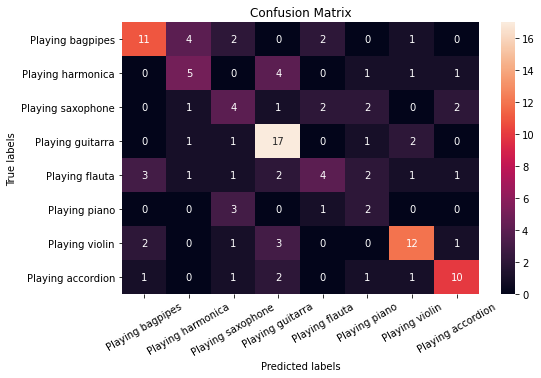

In [43]:
# get ground-truth split
name_to_int = {v:k for k,v in test_data.class_names.items()}

split_idx = []
for idx, y_name in enumerate(y_test):
    if idx == 0 or y_name != y_test[idx-1]:
        split_idx.append(idx)

y_pred_test = []
for i, split in enumerate(split_idx):
    if i < len(split_idx) - 1:
        y_pred_test.append(np.argmax(np.mean(y_test_prob[split:split_idx[i+1]], axis=0)))
        
# Display the testing results
acc = accuracy_score(ground_truth, y_pred_test)

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
print("General Accuracy: {}\n".format(accuracy_score(ground_truth, y_pred_test)))
print(classification_report(ground_truth, y_pred_test, target_names=list(test_data.class_names.values())))

cm = confusion_matrix(ground_truth, y_pred_test, labels=list(test_data.class_names.keys()))
import seaborn as sns
import matplotlib.pyplot as plt     

fig=plt.figure(figsize=(8, 5))

ax = plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(list(test_data.class_names.values()), rotation=30); 
ax.yaxis.set_ticklabels(list(test_data.class_names.values()), rotation=0);

#### Performance of the seperate models with linear SVC final layer

##### ResNeXt-101 feature + linearSVM

General Accuracy: 0.5409836065573771

                   precision    recall  f1-score   support

 Playing bagpipes       0.67      0.60      0.63        20
Playing harmonica       0.50      0.50      0.50        12
Playing saxophone       0.29      0.33      0.31        12
 Playing guitarra       0.68      0.86      0.76        22
   Playing flauta       0.50      0.33      0.40        15
    Playing piano       0.44      0.67      0.53         6
   Playing violin       0.41      0.37      0.39        19
Playing accordion       0.64      0.56      0.60        16

         accuracy                           0.54       122
        macro avg       0.52      0.53      0.52       122
     weighted avg       0.54      0.54      0.53       122



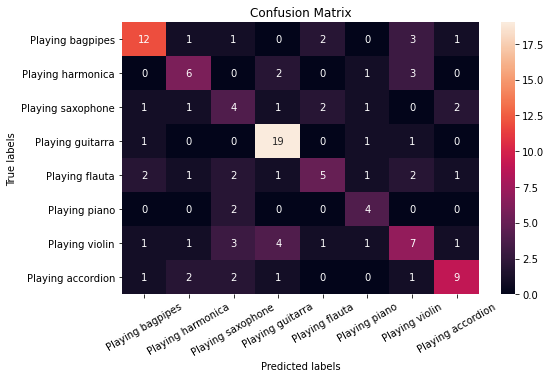

In [45]:
# get ground-truth split
name_to_int = {v:k for k,v in test_data.class_names.items()}

split_idx = []
for idx, y_name in enumerate(y_test):
    if idx == 0 or y_name != y_test[idx-1]:
        split_idx.append(idx)

y_pred_test = []
for i, split in enumerate(split_idx):
    if i < len(split_idx) - 1:
        y_pred_test.append(np.argmax(np.mean(y_test_prob1[split:split_idx[i+1]], axis=0)))
        
# Display the testing results
acc = accuracy_score(ground_truth, y_pred_test)

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
print("General Accuracy: {}\n".format(accuracy_score(ground_truth, y_pred_test)))
print(classification_report(ground_truth, y_pred_test, target_names=list(test_data.class_names.values())))

cm = confusion_matrix(ground_truth, y_pred_test, labels=list(test_data.class_names.keys()))
import seaborn as sns
import matplotlib.pyplot as plt     

fig=plt.figure(figsize=(8, 5))

ax = plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(list(test_data.class_names.values()), rotation=30); 
ax.yaxis.set_ticklabels(list(test_data.class_names.values()), rotation=0);

##### Resnet-50 feature + linearSVM

General Accuracy: 0.45901639344262296

                   precision    recall  f1-score   support

 Playing bagpipes       0.57      0.40      0.47        20
Playing harmonica       0.19      0.25      0.21        12
Playing saxophone       0.50      0.42      0.45        12
 Playing guitarra       0.53      0.77      0.63        22
   Playing flauta       0.40      0.13      0.20        15
    Playing piano       0.33      0.67      0.44         6
   Playing violin       0.39      0.37      0.38        19
Playing accordion       0.67      0.62      0.65        16

         accuracy                           0.46       122
        macro avg       0.45      0.45      0.43       122
     weighted avg       0.47      0.46      0.45       122



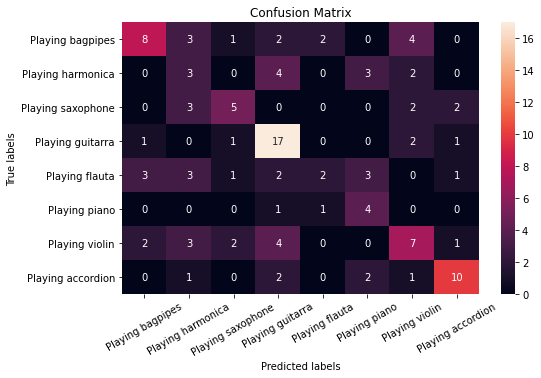

In [46]:
# get ground-truth split
name_to_int = {v:k for k,v in test_data.class_names.items()}

split_idx = []
for idx, y_name in enumerate(y_test):
    if idx == 0 or y_name != y_test[idx-1]:
        split_idx.append(idx)

y_pred_test = []
for i, split in enumerate(split_idx):
    if i < len(split_idx) - 1:
        y_pred_test.append(np.argmax(np.mean(y_test_prob2[split:split_idx[i+1]], axis=0)))
        
# Display the testing results
acc = accuracy_score(ground_truth, y_pred_test)

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
print("General Accuracy: {}\n".format(accuracy_score(ground_truth, y_pred_test)))
print(classification_report(ground_truth, y_pred_test, target_names=list(test_data.class_names.values())))

cm = confusion_matrix(ground_truth, y_pred_test, labels=list(test_data.class_names.keys()))
import seaborn as sns
import matplotlib.pyplot as plt     

fig=plt.figure(figsize=(8, 5))

ax = plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(list(test_data.class_names.values()), rotation=30); 
ax.yaxis.set_ticklabels(list(test_data.class_names.values()), rotation=0);